# Trial segmentation & Behavior

![](attachments/timelocks.png)

In this notebook, we identify interesting time points within the EEG recording and extract surrounding time intervals for analysis. Trial-level analysis is much enhanced when behavioral data for each trial is available. So, as we identify the trials, we additionally characterize the behavior during individual trials based on event codes that are embedded in the EEG recording.

In [28]:
import mne
from glob import glob as ls
import matplotlib.pyplot as plt
import numpy as np, pandas as pd

## Configuration
The key ingredient for trial segmentation besides the EEG recording are the **event markers** that characterize stimuli and behavior in each trial. In the section below, we define some labels and their function in the experiment. In particular we have the beginning and end of blocks and trials, as well as **stimulus, probe, response, and feedback** of different types. Those can be used for time-locks and to define trials as time intervals in the EEG recording. The specific numerical event codes can be found in the Psychtoolbox/Matlab code for the experiment.

Note that we also have a function `get_metadata` that determines a number of interesting properties of each trial, and returns a table with a row per trial.

In [82]:
block_ids = ['Stim/S  3','Stim/S  4']
trial_ids = ['Stim/S  5','Stim/S  6']
probe_id =  'Stim/S 57'
stimulus_id = {'size1':'Stim/S 11','size2':'Stim/S 25','size4':'Stim/S 43'}
response_id =  {'all':'Stim/S 60','correct': 'Stim/S 64', 'incorrect': 'Stim/S 65'}
feedback_id = {'size1':'Stim/S 72','size2':'Stim/S 73','size4':'Stim/S 74'}
def get_metadata(evt,ids):
    md = {"Block":[],"Trial":[],"Size":[],"RT":[],"Correct":[]}
    size_id = {ids[stimulus_id['size1']]:1,ids[stimulus_id['size2']]:2,ids[stimulus_id['size4']]:4}
    correct_id = {ids[response_id['correct']]:1}
    blocks = list(zip(np.where(evt[:,2]==ids[block_ids[0]])[0],np.where(evt[:,2]==ids[block_ids[1]])[0]))
    start_id = ids[probe_id]
    end_id = ids[response_id['all']]
    for i,b in enumerate(blocks):
        evt_b = evt[b[0]+1:b[1],:]
        trials = list(zip(np.where(evt_b[:,2]==ids[trial_ids[0]])[0],np.where(evt_b[:,2]==ids[trial_ids[1]])[0]))
        for j,t in enumerate(trials):
            evt_t = evt_b[t[0]+1:t[1],:]
            md['Block'].extend([i+1])
            md['Trial'].extend([j+1])
            md['Correct'].extend([sum([correct_id.get(e,0) for e in evt_t[:,2]])])
            md['Size'].extend([sum([size_id.get(e,0) for e in evt_t[:,2]])])
            begin = sum([evt_t[k,0] for k,e in enumerate(evt_t[:,2]) if e==start_id])
            end = sum([evt_t[k,0] for k,e in enumerate(evt_t[:,2]) if e==end_id])
            md['RT'].extend([end-begin])
    return pd.DataFrame(md)

## Segmentation
Here we perform the segmentation. Note that in the example, we choose stimulus **event codes** for the time lock (`evt_id / evt_lck`), but any of the aforementioned event types can be used. During trial segmentation we specify the time before and after the event that is included in the epoched EEG data (`tmin / tmax`). It is useful to add ca. 500ms before and after the actual interval we are interested in, to avoid e.g. **edge artifacts** during frequency analysis.

After segmentation, we save the trials in a new EEG file (this can be repeated for different time locks) which has the metadata embedded. We also save an additional copy of the metadata to a spreadsheet file to allow easy access for behavioral analyses.

In [83]:
files = [f for f in sorted(ls("Data/s03/*-raw.fif.gz"))];files

['Data/s03/dmss03-raw.fif.gz']

In [84]:
for f in files:
    r = mne.io.read_raw(f, preload=True)
    evts, ids = mne.events_from_annotations(r)
    md = get_metadata(evts,ids)
    evt_id = {k:ids[v] for k,v in stimulus_id.items()}
    evt_lck = np.array([e for e in evt if e[2] in evt_id.values()])
    epoch = mne.Epochs(r,evt_lck,evt_id,tmin=-.7,tmax=1.7,baseline=(-.2,0),metadata=md,preload=True)
    epoch.save(f[:-11]+"_stim-epo.fif.gz",overwrite=True)
    md.to_csv(f[:-11]+".csv")

Opening raw data file Data/s03/dmss03-raw.fif.gz...
    Range : 0 ... 7643799 =      0.000 ...  7643.799 secs
Ready.
Reading 0 ... 7643799  =      0.000 ...  7643.799 secs...
Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stim/S  1'), np.str_('Stim/S  2'), np.str_('Stim/S  3'), np.str_('Stim/S  4'), np.str_('Stim/S  5'), np.str_('Stim/S  6'), np.str_('Stim/S 11'), np.str_('Stim/S 12'), np.str_('Stim/S 21'), np.str_('Stim/S 22'), np.str_('Stim/S 25'), np.str_('Stim/S 26'), np.str_('Stim/S 31'), np.str_('Stim/S 32'), np.str_('Stim/S 35'), np.str_('Stim/S 36'), np.str_('Stim/S 39'), np.str_('Stim/S 40'), np.str_('Stim/S 43'), np.str_('Stim/S 44'), np.str_('Stim/S 50'), np.str_('Stim/S 51'), np.str_('Stim/S 52'), np.str_('Stim/S 53'), np.str_('Stim/S 54'), np.str_('Stim/S 57'), np.str_('Stim/S 58'), np.str_('Stim/S 60'), np.str_('Stim/S 61'), np.str_('Stim/S 62'), np.str_('Stim/S 64'), np.str_('Stim/S 65'), np.str_('Stim/S 70'), np.str_('Stim/S 71'), np.str_('Stim/S 72')

## First look at the data

In [62]:
epoch

<Epochs | 683 events (all good), -0.7 – 1.7 s (baseline -0.2 – 0 s), ~725.7 MiB, data loaded, with metadata,
 'size1': 227
 'size2': 226
 'size4': 230>

Looking at the Epoch object, we see the **3 bad channels** carried over from preprocessing (it is okay to clear them, since they have been interpolated). We also notice that of the original 720 trials, 683 were clean - a **trial rejection rate of about 5%** is okay. We may want to balance the number of trials for each condition / event type in subsequent analyses.

Used Annotations descriptions: [np.str_('Stim/S  1'), np.str_('Stim/S  3'), np.str_('Stim/S  5'), np.str_('Stim/S  6'), np.str_('Stim/S 11'), np.str_('Stim/S 12'), np.str_('Stim/S 21'), np.str_('Stim/S 22'), np.str_('Stim/S 25'), np.str_('Stim/S 26'), np.str_('Stim/S 31'), np.str_('Stim/S 32'), np.str_('Stim/S 35'), np.str_('Stim/S 36'), np.str_('Stim/S 39'), np.str_('Stim/S 40'), np.str_('Stim/S 43'), np.str_('Stim/S 44'), np.str_('Stim/S 50'), np.str_('Stim/S 51'), np.str_('Stim/S 52'), np.str_('Stim/S 53'), np.str_('Stim/S 54'), np.str_('Stim/S 57'), np.str_('Stim/S 58'), np.str_('Stim/S 60'), np.str_('Stim/S 61'), np.str_('Stim/S 62'), np.str_('Stim/S 64'), np.str_('Stim/S 65'), np.str_('Stim/S 70'), np.str_('Stim/S 71'), np.str_('Stim/S 72'), np.str_('Stim/S 73'), np.str_('Stim/S 74')]


/var/folders/9z/wdzscs1d11s28758n1wm54wh00_b1l/T/ipykernel_90402/1117366247.py:2: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(evt,r.info['sfreq'],event_id=ids,first_samp=45000);


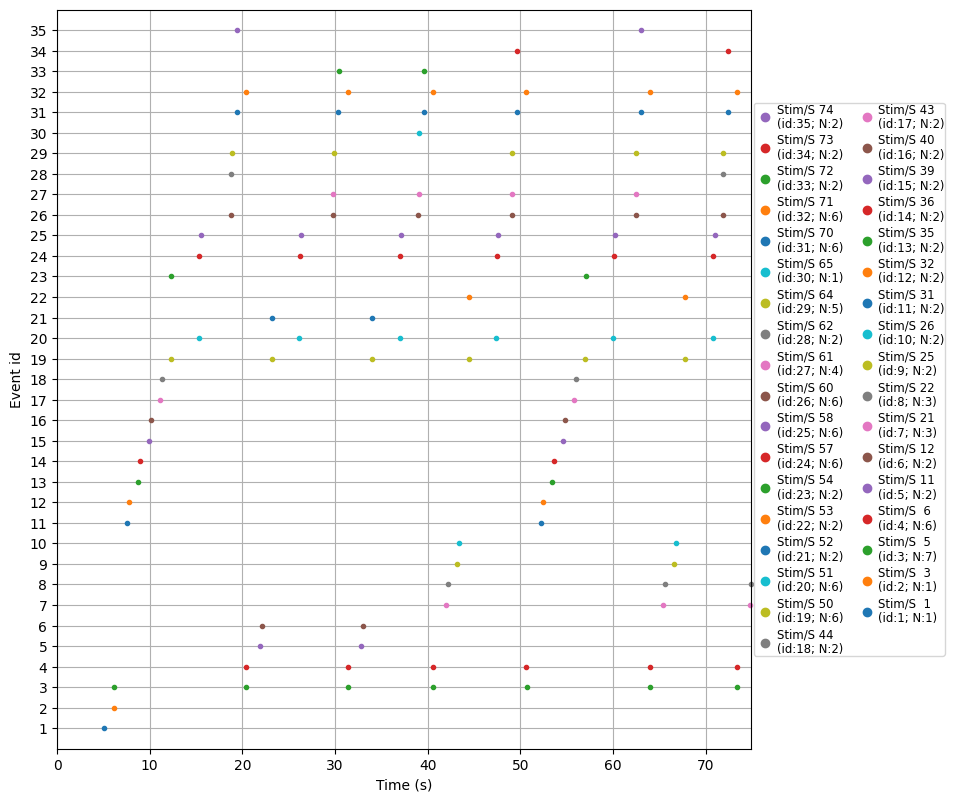

In [11]:
evt, ids = mne.events_from_annotations(r.copy().crop(40,120));
mne.viz.plot_events(evt,r.info['sfreq'],event_id=ids,first_samp=45000);

Not too much insight can be gathered from this view on the events in our experiment, but it may give you an impression of how fine-grained you want to record behavior in order to enable interesting analyses in later steps.

Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 3301 samples (3.301 s)



/var/folders/9z/wdzscs1d11s28758n1wm54wh00_b1l/T/ipykernel_90402/2134720440.py:1: RuntimeWarning: filter_length (3301) is longer than the signal (2401), distortion is likely. Reduce filter length or filter a longer signal.
  evoked = epoch.copy().filter(1,20).average()


Applying baseline correction (mode: mean)
No projector specified for this dataset. Please consider the method self.add_proj.


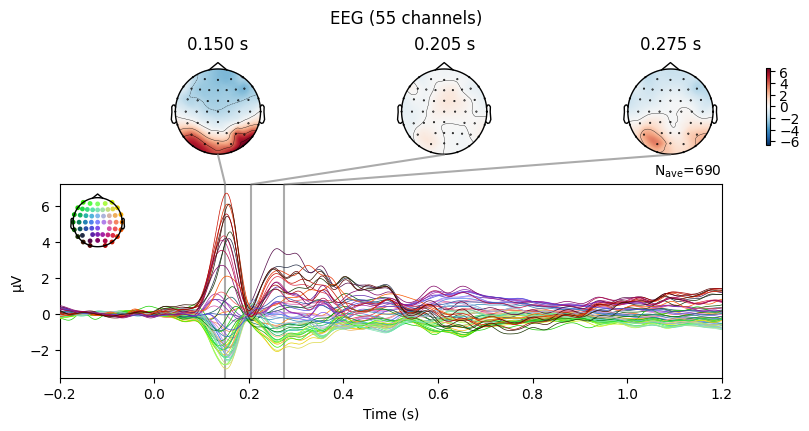

In [85]:
evoked = epoch.copy().filter(1,20).average()
evoked.apply_baseline((-.2,0)).plot_joint(times=[0.15,0.205,0.275],ts_args={'xlim':(-.2,1.2)});

This is a first glance at the evoked potentials. The things we check are a flat baseline period (-200ms to 0ms), as well as clean visual ERPs such as P1 (posterior peak around 150ms) and N1 (the dip afterwards). This being a memory task, we can also notice the P300 potential, a cognitive signature indicated by a posterior peak around 300ms that gradually dissipates.

For this recording everything looks alright, except for the bright green channel that shows drift during the baseline period - we may want to manually mark it for interpolation.

In [81]:
md.groupby(['Size']).mean()

,Block,Trial,RT,Correct
Size,,,,
1,15.5,12.029167,853.245833,0.904167
2,15.5,12.420833,891.683333,0.945833
4,15.5,13.050000,1024.095833,0.887500


Using the experimental meta data, we can take a first glance at the subject's behavior. We notice that the response time increases with higher memory loads. But the low accuracy for single memory items compaired to pairs is suprising and worth investigating!